In [54]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch 
import json 
import re
from typing import List, Dict
import pandas as pd

# Comparative Analysis betwen Pretrained Llava and its Fine Tuned Version

### Training Loss vs Validation Loss:

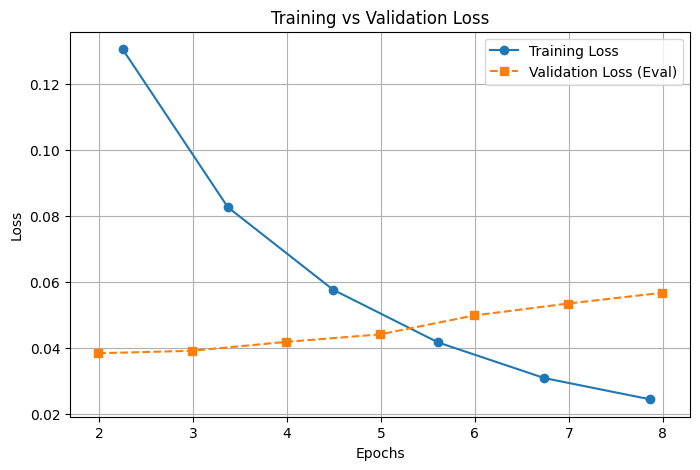

In [41]:
slurm_path = r'C:\Users\arbio\OneDrive\Bureau\centrale supelec\MVA\Deep Learning\Llava\logslurms\slurm-92363.out'
# Read the log file
with open(slurm_path, "r") as f:
    log_data = f.readlines()

# Initialize lists to store values
epochs = []
losses = []
eval_epochs = []
eval_losses = []
perplexities = []

# Regular expressions to extract values
loss_pattern = re.compile(r"\{'loss': ([\d\.]+), .* 'epoch': ([\d\.]+)\}")
eval_loss_pattern = re.compile(r"\{'eval_loss': ([\d\.]+), .* 'epoch': ([\d\.]+)\}")

# Parse the file
for line in log_data:
    loss_match = loss_pattern.search(line)
    eval_loss_match = eval_loss_pattern.search(line)

    if loss_match:
        loss, epoch = map(float, loss_match.groups())
        losses.append(loss)
        epochs.append(epoch)

    if eval_loss_match:
        eval_loss, eval_epoch = map(float, eval_loss_match.groups())
        eval_losses.append(eval_loss)
        eval_epochs.append(eval_epoch)
        perplexities.append(np.exp(eval_loss))  # Compute perplexity

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(epochs[1:], losses[1:], marker='o', linestyle='-', label="Training Loss")
plt.plot(eval_epochs[1:], eval_losses[1:], marker='s', linestyle='--', label="Validation Loss (Eval)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


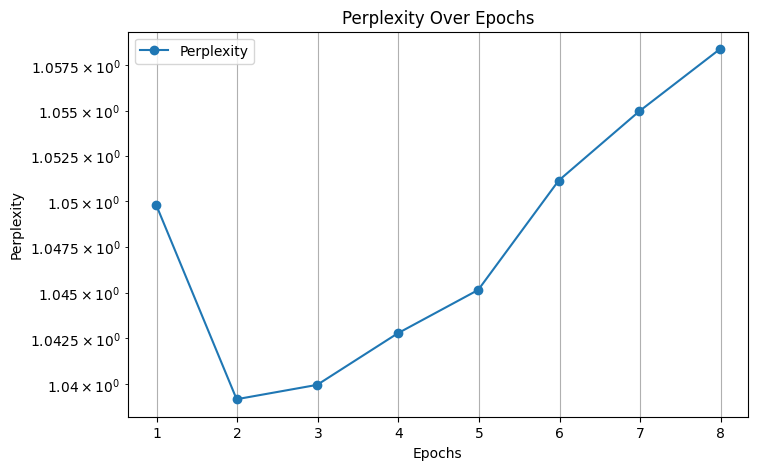

Final Perplexity at epoch 7.99: 1.0584


In [42]:
# Plot perplexity over epochs
plt.figure(figsize=(8, 5))
plt.plot(eval_epochs, perplexities, marker='o', linestyle='-', label="Perplexity")

plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity Over Epochs")
plt.yscale("log")  # Use log scale if values vary significantly
plt.legend()
plt.grid(True)
plt.show()

# Print final perplexity
print(f"Final Perplexity at epoch {eval_epochs[-1]}: {perplexities[-1]:.4f}")


After analyzing the Training Loss vs. Validation Loss and the model's perplexity, we better understand why the base model was loaded at epoch 2.  

For the following steps, the fine-tuned model from the checkpoint at epoch 2 will be used.

### Pretrained Model Performance:

In [11]:
finetuned_path  = r'C:\Users\arbio\OneDrive\Bureau\centrale supelec\MVA\Deep Learning\Llava\evaluation_finetuned.json'
pretrained_path = r'C:\Users\arbio\OneDrive\Bureau\centrale supelec\MVA\Deep Learning\Llava\evaluation_pretrained.json'

with open(pretrained_path, "r") as f:
    pretrained_res = json.load(f)

with open(finetuned_path, "r") as f:
    finetuned_res = json.load(f)

In [49]:
def evaluate_performance(outputs: List[str]) -> Dict[str, float]:
    # Initialize counters
    counts = {
        'correct': 0,
        'incorrect': 0,
        'neutral': 0,
        'invalid_format': 0,
        'confidence_values': [],
        'contradictions': 0  # Both correct and incorrect marked true
    }

    # Regex patterns with flexible matching
    patterns = {
        'correct': re.compile(r'contains_correct_finding\s*:\s*(true|false)', re.IGNORECASE),
        'incorrect': re.compile(r'has_incorrect_info\s*:\s*(true|false)', re.IGNORECASE),
        'confidence': re.compile(r'confidence\s*:\s*(\d+)')
    }

    for raw_output in outputs:
        # Normalize the output text
        output = ' '.join(raw_output.replace('\n', ' ').lower().split())
        
        # Extract values with regex
        try:
            correct_match = patterns['correct'].search(output)
            incorrect_match = patterns['incorrect'].search(output)
            confidence_match = patterns['confidence'].search(output)

            # Handle confidence
            confidence = int(confidence_match.group(1)) if confidence_match else None
            if confidence is not None:
                confidence = max(0, min(5, confidence))  # Clamp to 0-5

            # Validate and classify response
            if not correct_match and not incorrect_match:
                counts['invalid_format'] += 1
                continue

            correct = correct_match.group(1).lower() == 'true' if correct_match else False
            incorrect = incorrect_match.group(1).lower() == 'true' if incorrect_match else False

            # Check for logical contradictions
            if correct and incorrect:
                counts['contradictions'] += 1
                continue

            # Classification logic
            if correct:
                counts['correct'] += 1
                if confidence is not None:
                    counts['confidence_values'].append(confidence)
            elif incorrect:
                counts['incorrect'] += 1
            elif not correct and not incorrect:
                counts['neutral'] += 1

        except (AttributeError, ValueError) as e:
            counts['invalid_format'] += 1
            continue

    # Calculate metrics
    total_valid = sum(counts[k] for k in ['correct', 'incorrect', 'neutral', 'contradictions'])
    total_responses = len(outputs)

    metrics = {
        'total_responses': total_responses,
        'valid_responses': total_valid,
        'correct_rate': round(counts['correct'] / total_valid, 2) if total_valid else 0,
        'incorrect_rate': round(counts['incorrect'] / total_valid, 2) if total_valid else 0,
        'neutral_rate': round(counts['neutral'] / total_valid, 2) if total_valid else 0,
        'contradiction_rate': round(counts['contradictions'] / total_responses, 2),
        'invalid_format_rate': round(counts['invalid_format'] / total_responses, 2),
        'average_confidence': round((sum(counts['confidence_values']) / len(counts['confidence_values'])), 2)
                            if counts['confidence_values'] else None,
        'confidence_completeness': round(len(counts['confidence_values']) / counts['correct'], 2)
                                  if counts['correct'] else 0
    }

    return metrics

In [67]:
pre_trained_perf = pd.DataFrame.from_dict(evaluate_performance(pretrained_res) , orient='index', columns=['Pre-Trained Model'])
finetuned_perf = pd.DataFrame.from_dict(evaluate_performance(finetuned_res) , orient='index', columns=['Fine-Tuned Model'])

compare_perf = pd.concat([pre_trained_perf, finetuned_perf], axis=1)

In [68]:
compare_perf

,Pre-Trained Model,Fine-Tuned Model
total_responses,451.00,451.00
valid_responses,426.00,407.00
correct_rate,0.51,0.47
incorrect_rate,0.42,0.48
neutral_rate,0.07,0.05
contradiction_rate,0.00,0.00
invalid_format_rate,0.06,0.10
average_confidence,4.89,4.76
confidence_completeness,1.00,1.00


### Key Takeaways
- The **correct rate** decreased from **51% to 47%**, while the **incorrect rate** increased from **42% to 48%**.
- The **invalid format rate** increased from **6% to 10%**, indicating more formatting inconsistencies.
- The **average confidence** of responses slightly dropped from **4.89 to 4.76**.
- **Contradiction rate remained at 0**, meaning the model did not produce directly conflicting responses.

## Potential Causes & Next Steps
The decline in performance may be attributed to several factors:
- **Catastrophic forgetting**.
- **Misalignment between fine-tuning objectives and evaluation methodology**: Evaluation was based on LLM-as-a judge, even though the use is justified given the nuanced model answers and that standard techniques (ROUGE, BLEU etc) cannot perform a soft match, the judge can give misleading and wrong evaluation.

To improve the model’s performance, the following steps could be explored:
- Refining the dataset to improve data quality.
- Adjusting fine-tuning hyperparameters to prevent catastrophic forgetting.
- Exploring reinforcement learning techniques such as **Direct Preference Optimization (DPO)**.

